<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: NIRCam, calwebb_image3, source_catalog

<span style="color:red"> **Instruments Affected**</span>: e.g., FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Set up Temporary Directory](#tempdir)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Image3Pipeline](#pipeline)
<br> [Perform Visual Inspection](#visualization) 
<br> [Manually Find Matches](#manual)
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the NIRCam validation notebook for the Source Catalog step, which generates a catalog based on input exposures.

* Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/source_catalog/index.html

* Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/source_catalog

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

This is the NIRCam imaging validation notebook for the Source Catalog step, which uses image combinations or stacks of overlapping images to generate "browse-quality" source catalogs.  Having automated source catalogs will help accelerate the science output of JWST. The source catalogs should include both point and "slightly" extended sources at a minimum.  The catalog should provide an indication if the source is a point or an extended source. For point sources, the source catalog should include measurements corrected to infinite aperture using aperture corrections provided by a reference file.  

See: 
* https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Point+Source+Catalog


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

* JWST: James Webb Space Telescope

* NIRCam: Near-Infrared Camera


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

Here we generate the source catalog and visually inspect a plot of the image with the source catalog overlaid. We also look at some other diagnostic plots and then cross-check the output catalog against Mirage catalog inputs. 


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

The set of data used in this test were created with the Mirage simulator. The simulator created a NIRCam imaging mode exposures for the short wave NRCA1 detector. 


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

In [1]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeavsellc


[Top of Page](#title_ID)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


[Top of Page](#title_ID)

<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.


* astropy for various tools and packages
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for JWST Pipeline data models
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

In [3]:
# plotting, the inline must come before the matplotlib import
%matplotlib inline
# %matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

from matplotlib import pyplot as plt
import matplotlib.patches as patches

params = {'legend.fontsize': 6,
          'figure.figsize': (8, 8),
          'figure.dpi': 150,
         'axes.labelsize': 6,
         'axes.titlesize': 6,
         'xtick.labelsize':6,
         'ytick.labelsize':6}
plt.rcParams.update(params)

# Box download imports 
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

# python general
import os
import numpy as np

# astropy modules
import astropy
from astropy.io import fits
from astropy.table import QTable, Table, vstack, unique
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import units as u
import photutils

# jwst 
from jwst.pipeline import calwebb_image3
from jwst import datamodels

In [4]:
def create_image(data_2d, xpixel=None, ypixel=None, title=None):
    ''' Function to generate a 2D image of the data, 
    with an option to highlight a specific pixel.
    '''
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()

    norm = simple_norm(data_2d, 'sqrt', percent=99.)
    
    plt.imshow(data_2d, norm=norm, origin='lower', cmap='gray')
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    if title:
        plt.title(title)

    plt.subplots_adjust(left=0.15)
    plt.colorbar(label='MJy/sr')

In [5]:
def create_image_with_cat(data_2d, catalog, flux_limit=None, title=None):
    ''' Function to generate a 2D image of the data, 
    with sources overlaid.
    '''
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()

    norm = simple_norm(data_2d, 'sqrt', percent=99.)
    
    plt.imshow(data_2d, norm=norm, origin='lower', cmap='gray')
    
    for row in catalog:
        if flux_limit:
            if np.isnan(row['aper_total_flux']):
                pass
            else:
                if row['aper_total_flux'] > flux_limit:
                    plt.plot(row['xcentroid'], row['ycentroid'], marker='o', markersize='3', color='red')
        else:
            plt.plot(row['xcentroid'], row['ycentroid'], marker='o', markersize='1', color='red')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    if title:
        plt.title(title)

    plt.subplots_adjust(left=0.15)
    plt.colorbar(label='MJy/sr')

In [6]:
def create_scatterplot(catalog_colx, catalog_coly, title=None):
    ''' Function to generate a generic scatterplot.
    '''
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    ax.scatter(catalog_colx,catalog_coly) 
    plt.xlabel(catalog_colx.name)
    plt.ylabel(catalog_coly.name)

    
    if title:
        plt.title(title)

In [7]:
def get_input_table(sourcelist):
    '''Function to read in and access the simulator source input files.'''

    all_source_table = Table()

    # point source and galaxy source tables have different headers
    # change column headers to match for filtering later
    if "point" in sourcelist:
        col_names = ["RA", "Dec", "RA_degrees", "Dec_degrees",
                     "PixelX", "PixelY", "Magnitude",
                     "counts_sec", "counts_frame"]
    elif "galaxy" in sourcelist:
        col_names = ["PixelX", "PixelY", "RA", "Dec",
                     "RA_degrees", "Dec_degrees", "V2", "V3", "radius",
                     "ellipticity", "pos_angle", "sersic_index",
                     "Magnitude", "countrate_e_s", "counts_per_frame_e"]
    else:
        print('Error! Source list column names need to be defined.')
        sys.exit(0)

    # read in the tables
    input_source_table = Table.read(sourcelist,format='ascii')
    orig_colnames = input_source_table.colnames

    # only grab values for source catalog analysis
    short_source_table = Table({'In_RA': input_source_table['RA_degrees'],
                              'In_Dec': input_source_table['Dec_degrees']},
                              names=['In_RA', 'In_Dec'])

    # combine source lists into one master list
    all_source_table = vstack([all_source_table, short_source_table])

    # set up columns to track which sources were detected by Photutils
    all_source_table['Out_RA'] = np.nan
    all_source_table['Out_Dec'] = np.nan
    all_source_table['Detected'] = 'N'
    all_source_table['RA_Diff'] = np.nan
    all_source_table['Dec_Diff'] = np.nan

    # filter by RA, Dec (for now)
    no_duplicates = unique(all_source_table,keys=['In_RA','In_Dec'])

    return no_duplicates

[Top of Page](#title_ID)

<a id="data_load"></a>
# Loading the Data

The simulated exposures used for this test are stored in Box. Grab them. 

In [8]:
def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url, timeout=600)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

file_urls = ['https://stsci.box.com/shared/static/72fds4rfn4ppxv2tuj9qy2vbiao110pc.fits', 
             'https://stsci.box.com/shared/static/gxwtxoz5abnsx7wriqligyzxacjoz9h3.fits', 
             'https://stsci.box.com/shared/static/tninaa6a28tsa1z128u3ffzlzxr9p270.fits',
             'https://stsci.box.com/shared/static/g4zlkv9qi0vc5brpw2lamekf4ekwcfdn.json',
             'https://stsci.box.com/shared/static/kvusxulegx0xfb0uhdecu5dp8jkeluhm.list']

file_names = ['jw00042002001_01101_00004_nrca5_cal.fits', 
             'jw00042002001_01101_00005_nrca5_cal.fits', 
             'jw00042002001_01101_00006_nrca5_cal.fits',
             'level3_lw_imaging_files_asn.json',
             'jw00042002001_01101_00004_nrca5_uncal_galaxySources.list']

box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]

In [9]:
get_box_files(box_download_list)

[Top of Page](#title_ID)

<a id="pipeline"></a>
# Run the Image3Pipeline

Run calwebb_image3 to get the output source catalog and the final 2D image. 

In [10]:
img3 = calwebb_image3.Image3Pipeline()

2022-07-07 08:20:20,572 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-07-07 08:20:20,574 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-07-07 08:20:20,577 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-07-07 08:20:20,581 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-07-07 08:20:20,585 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-07-07 08:20:20,589 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-07-07 08:20:20,592 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


In [11]:
img3.assign_mtwcs.skip=True
img3.save_results=True
img3.resample.save_results=True
img3.source_catalog.snr_threshold = 5
img3.source_catalog.save_results=True

In [12]:
img3.run(file_names[3])

2022-07-07 08:20:20,730 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('level3_lw_imaging_files_asn.json',).


2022-07-07 08:20:20,737 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 

2022-07-07 08:20:21,827 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw00042002001_01101_00004_nrca5_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-07-07 08:20:22,420 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_nircam_abvegaoffset_0001.asdf'.


2022-07-07 08:20:22,423 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nircam_apcorr_0004.fits'.


2022-07-07 08:20:22,425 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.


2022-07-07 08:20:22,427 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-07-07 08:20:23,518 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-07-07 08:20:23,521 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 15, 'searchrad': 2.0, 'use2dhist': True, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2022-07-07 08:20:25,982 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw00042002001_01101_00004_nrca5_cal.fits.


2022-07-07 08:20:28,857 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw00042002001_01101_00005_nrca5_cal.fits.


2022-07-07 08:20:31,637 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw00042002001_01101_00006_nrca5_cal.fits.


2022-07-07 08:20:31,652 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-07-07 08:20:31,653 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 3.


2022-07-07 08:20:31,654 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-07-07 08:20:31,677 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw00042002001_01101_00004_nrca5_cal':


2022-07-07 08:20:31,678 - stpipe.Image3Pipeline.tweakreg - INFO -      jw00042002001_01101_00004_nrca5_cal


2022-07-07 08:20:31,698 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw00042002001_01101_00005_nrca5_cal':


2022-07-07 08:20:31,699 - stpipe.Image3Pipeline.tweakreg - INFO -      jw00042002001_01101_00005_nrca5_cal


2022-07-07 08:20:31,720 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw00042002001_01101_00006_nrca5_cal':


2022-07-07 08:20:31,721 - stpipe.Image3Pipeline.tweakreg - INFO -      jw00042002001_01101_00006_nrca5_cal


2022-07-07 08:20:31,722 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-07-07 08:20:31,723 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-07-07 08:20:31,724 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-07-07 08:20:31.723636


2022-07-07 08:20:31,725 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.4


2022-07-07 08:20:31,726 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-07-07 08:20:31,818 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: jw00042002001_01101_00004_nrca5_cal' as reference image


2022-07-07 08:20:31,826 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw00042002001_01101_00005_nrca5_cal' to the reference catalog.


2022-07-07 08:20:31,988 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw00042002001_01101_00005_nrca5_cal' catalog with sources from the reference 'jw00042002001_01101_00004_nrca5_cal' catalog.


2022-07-07 08:20:31,990 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...


2022-07-07 08:20:31,993 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -8.223e-05, 0.002618 with significance of 71.01 and 189 matches.


2022-07-07 08:20:31,994 - stpipe.Image3Pipeline.tweakreg - INFO - Found 121 matches for 'GROUP ID: jw00042002001_01101_00005_nrca5_cal'...


2022-07-07 08:20:31,996 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2022-07-07 08:20:32,000 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: jw00042002001_01101_00005_nrca5_cal:


2022-07-07 08:20:32,000 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00729029  YSH: 0.0307948    ROT: -0.00375344    SCALE: 1


2022-07-07 08:20:32,001 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-07-07 08:20:32,002 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0237067   FIT MAE: 0.0185097


2022-07-07 08:20:32,002 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 120 objects.


2022-07-07 08:20:32,037 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw00042002001_01101_00006_nrca5_cal' to the reference catalog.


2022-07-07 08:20:32,198 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw00042002001_01101_00006_nrca5_cal' catalog with sources from the reference 'jw00042002001_01101_00004_nrca5_cal' catalog.


2022-07-07 08:20:32,199 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...


2022-07-07 08:20:32,202 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.04178, 0.07048 with significance of 88.73 and 224 matches.


2022-07-07 08:20:32,203 - stpipe.Image3Pipeline.tweakreg - INFO - Found 153 matches for 'GROUP ID: jw00042002001_01101_00006_nrca5_cal'...


2022-07-07 08:20:32,205 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2022-07-07 08:20:32,209 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: jw00042002001_01101_00006_nrca5_cal:


2022-07-07 08:20:32,209 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0264291  YSH: 0.0101552    ROT: -0.000931682    SCALE: 1


2022-07-07 08:20:32,210 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-07-07 08:20:32,211 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0141971   FIT MAE: 0.0114097


2022-07-07 08:20:32,212 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 152 objects.


2022-07-07 08:20:32,246 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-07-07 08:20:32,247 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-07-07 08:20:32.246451


2022-07-07 08:20:32,247 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.522815


2022-07-07 08:20:32,248 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-07-07 08:20:32,363 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-07-07 08:20:32,534 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-07-07 08:20:32,537 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-07-07 08:20:32,676 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-07-07 08:20:32,677 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-07-07 08:20:32.675970


2022-07-07 08:20:32,678 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-07-07 08:20:32,679 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'match'


2022-07-07 08:20:32,680 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-07-07 08:20:32,681 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-07-07 08:20:32,682 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-07-07 08:20:32,682 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-07-07 08:20:35,647 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00004_nrca5_cal.fits. Sky background: 0.000528526


2022-07-07 08:20:35,649 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00005_nrca5_cal.fits. Sky background: 0


2022-07-07 08:20:35,650 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00006_nrca5_cal.fits. Sky background: 0.000410363


2022-07-07 08:20:35,651 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-07-07 08:20:35,652 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-07-07 08:20:35.651126


2022-07-07 08:20:35,653 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:02.975156


2022-07-07 08:20:35,654 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-07-07 08:20:35,667 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-07-07 08:20:35,800 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-07-07 08:20:35,802 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2022-07-07 08:20:35,809 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 3 inputs


2022-07-07 08:20:39,562 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:20:45,993 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:20:52,256 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:20:55,870 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 3 images


2022-07-07 08:20:57,144 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2022-07-07 08:21:00,680 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2246, 2456)


2022-07-07 08:21:05,237 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2246, 2456)


2022-07-07 08:21:09,804 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2246, 2456)


2022-07-07 08:21:09,904 - stpipe.Image3Pipeline.outlier_detection - INFO - Flagging outliers


2022-07-07 08:21:10,352 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 7297 (0.17%)


2022-07-07 08:21:10,772 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 6743 (0.16%)


2022-07-07 08:21:11,180 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 7404 (0.18%)


2022-07-07 08:21:11,407 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in jw00042002001_01101_00004_nrca5_a3001_crf.fits


2022-07-07 08:21:11,624 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in jw00042002001_01101_00005_nrca5_a3001_crf.fits


2022-07-07 08:21:11,837 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in jw00042002001_01101_00006_nrca5_a3001_crf.fits


2022-07-07 08:21:11,838 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-07-07 08:21:12,118 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-07-07 08:21:12,120 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-07-07 08:21:12,143 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits


2022-07-07 08:21:12,294 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for lw_imaging


2022-07-07 08:21:12,998 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-07-07 08:21:15,975 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:21:21,591 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:21:27,181 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:21:29,064 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-07-07 08:21:32,091 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:21:37,808 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:21:43,566 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:21:45,457 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-07-07 08:21:48,630 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:21:55,003 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:22:01,253 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:22:03,148 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-07-07 08:22:06,244 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:22:12,026 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:22:17,800 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2022-07-07 08:22:19,728 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  215.064179657 52.907896303 215.064162976 52.947155209 214.992916650 52.947122912 214.992997914 52.907864036


2022-07-07 08:22:20,271 - stpipe.Image3Pipeline.resample - INFO - Saved model in lw_imaging_i2d.fits


2022-07-07 08:22:20,272 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-07-07 08:22:20,489 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(2246, 2456) from lw_imaging_i2d.fits>,).


2022-07-07 08:22:20,491 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 5, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-07-07 08:22:20,514 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /grp/crds/cache/references/jwst/jwst_nircam_apcorr_0004.fits


2022-07-07 08:22:20,527 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file: /grp/crds/cache/references/jwst/jwst_nircam_abvegaoffset_0001.asdf


2022-07-07 08:22:20,528 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: NIRCAM


2022-07-07 08:22:20,529 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: NRCALONG


2022-07-07 08:22:20,530 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F356W


2022-07-07 08:22:20,530 - stpipe.Image3Pipeline.source_catalog - INFO - Pupil: CLEAR


2022-07-07 08:22:20,531 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-07-07 08:22:20,589 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 2.82390


2022-07-07 08:22:22,940 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 2357 sources


2022-07-07 08:22:24,932 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: lw_imaging_cat.ecsv


2022-07-07 08:22:25,082 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in lw_imaging_segm.fits


2022-07-07 08:22:25,084 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: lw_imaging_segm.fits


2022-07-07 08:22:25,086 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-07-07 08:22:25,087 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


[Top of Page](#title_ID)

<a id="visualization"></a>
# Perform Visual Inspection

Perform the visual inspection of the catalog and the final image. 

In [13]:
catalog = Table.read("lw_imaging_cat.ecsv")

In [14]:
combined_image = datamodels.ImageModel("lw_imaging_i2d.fits")

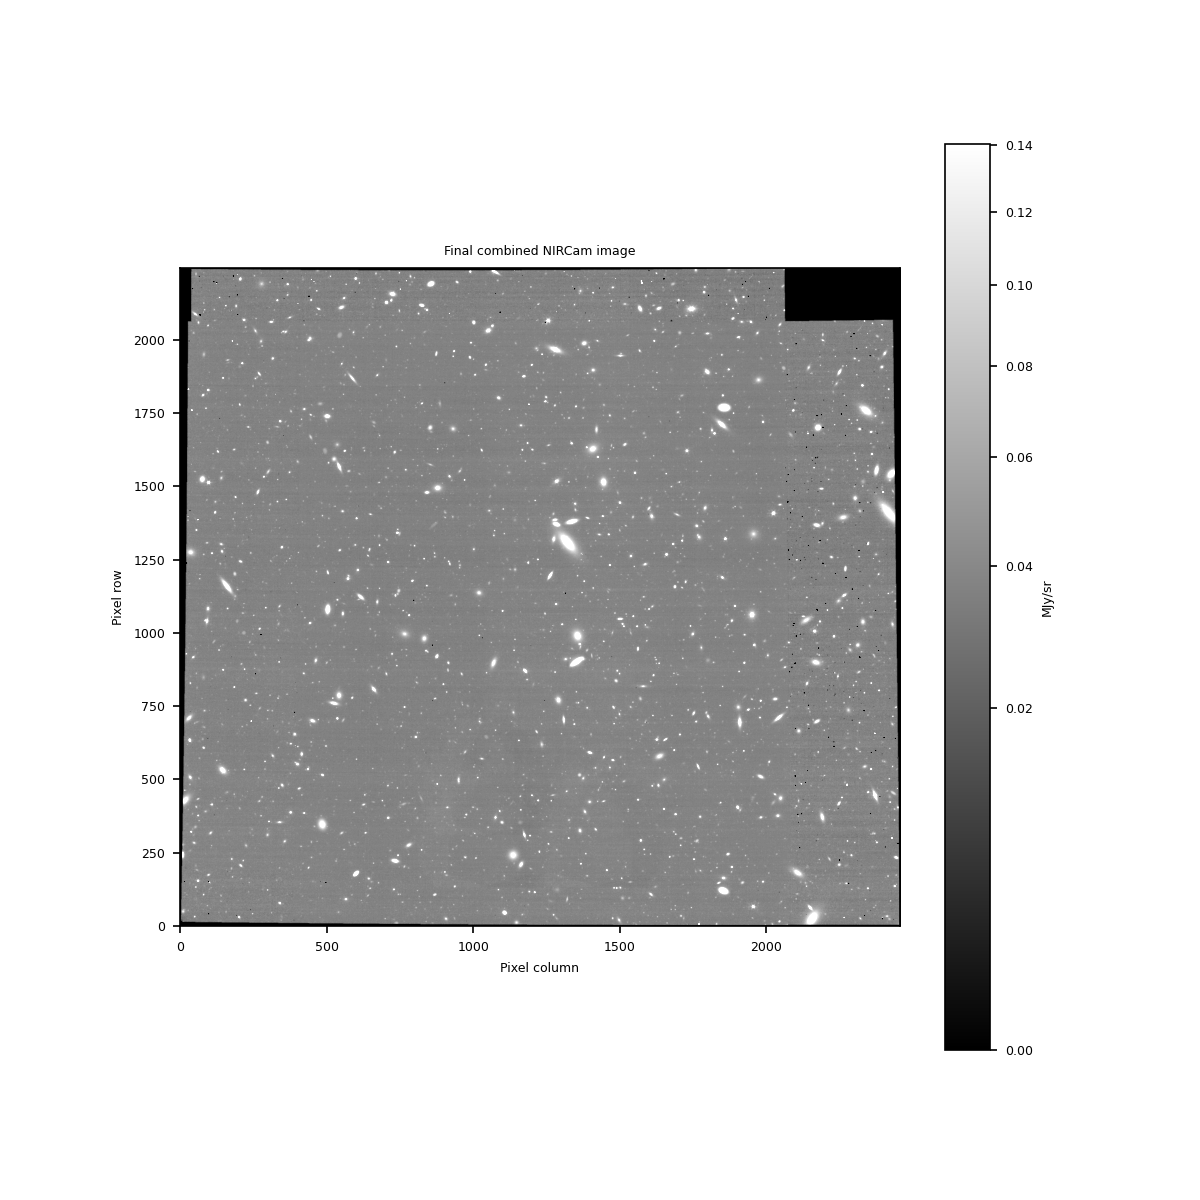

In [15]:
create_image(combined_image.data, title="Final combined NIRCam image")

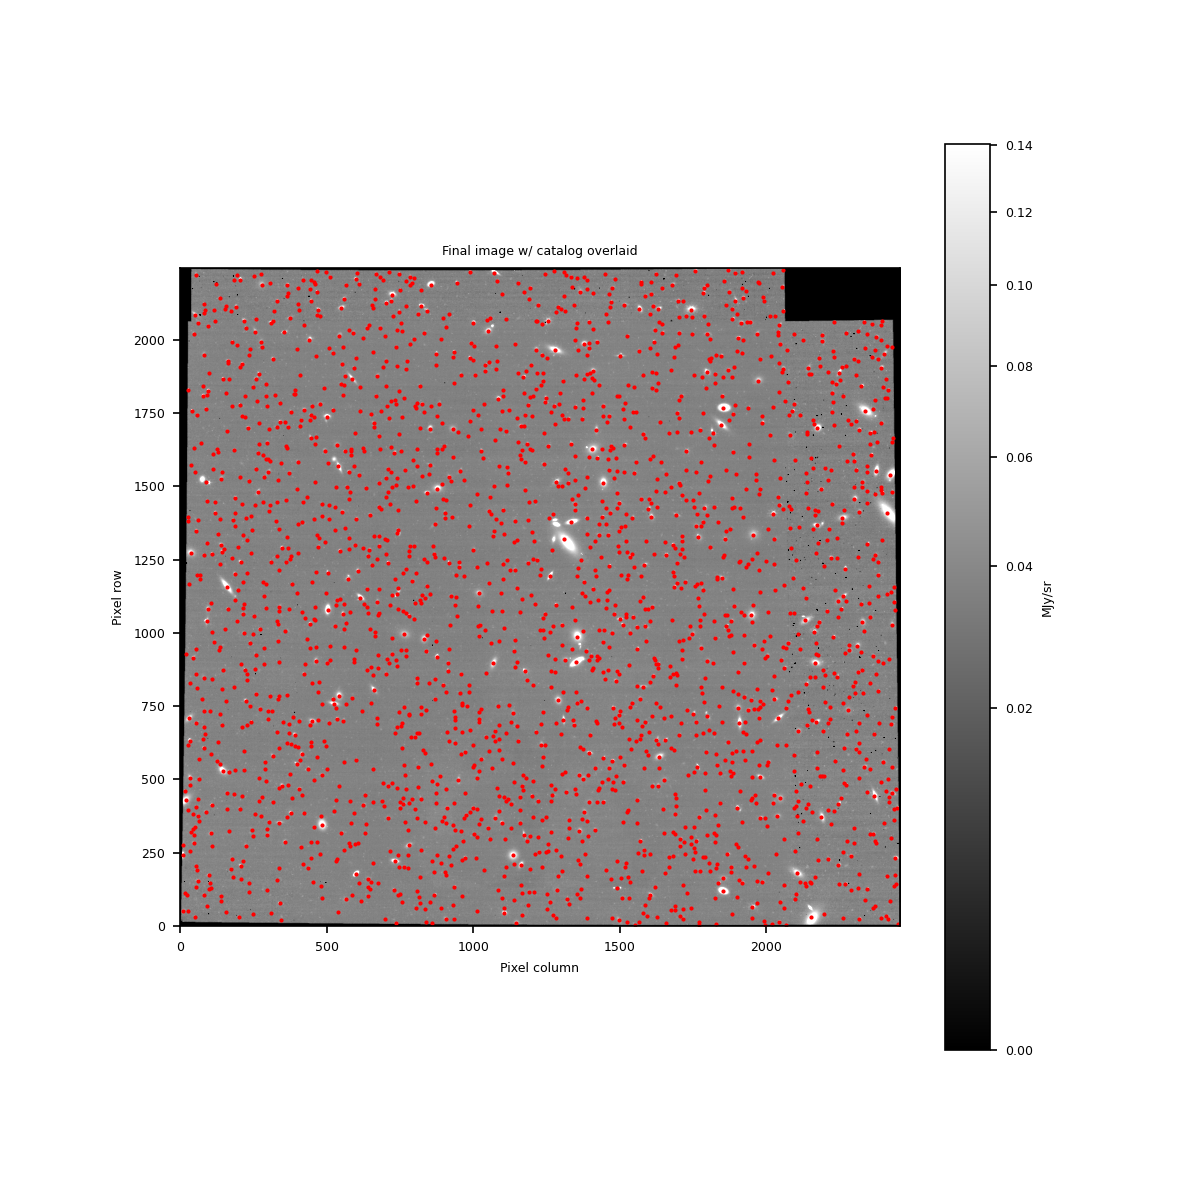

In [16]:
create_image_with_cat(combined_image.data, catalog, title="Final image w/ catalog overlaid")

In [17]:
catalog

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,SkyCoord,SkyCoord,SkyCoord,SkyCoord
1,1553.1816,4.5492,"215.0191639832401,52.90796036012613",0.000000e+00,4.499651e-11,1.086767e-08,1.062397e-02,1.953247e-08,nan,3.520692e-08,nan,5.151125e-08,nan,28.809659,14.975377,28.173107,nan,27.533430,nan,27.120245,nan,25.985759,14.975377,25.349207,nan,24.709530,nan,24.296345,nan,1.7973,1.8025,3.2396,False,0.651233,-0.067890,18,15.713614,2.730305e-08,1.785889e-02,27.809472,14.539110,24.985572,14.539110,8.0,0.881638,0.635913,0.278714,-13.582517,76.375167,"215.0192127483983,52.9079420462201","215.0192126461228,52.908011964103466","215.01906783423573,52.90794196903262","215.0190677317263,52.90801188691582"
2,1768.4872,5.1771,"215.01292379953887,52.90796784950847",0.000000e+00,2.918002e-11,5.062564e-06,2.228821e-01,7.454128e-06,2.611001e-01,7.871163e-06,nan,1.151630e-05,nan,22.139074,11.609286,21.719008,11.361057,21.659903,nan,21.246718,nan,19.315174,11.609286,18.895108,11.361057,18.836003,nan,18.422818,nan,1.4724,1.0559,1.5548,False,0.867732,-0.100007,15,7.890291,7.871234e-06,2.674216e-01,21.659893,11.327916,18.835993,11.327916,30.0,0.981076,0.900087,0.082551,-3.427973,86.529711,"215.0130394055962,52.90793860179649","215.01303923723347,52.9080434786122","215.0127785601504,52.9079384492116","215.012778391156,52.908043326026885"
3,1827.3064,6.6118,"215.01121900912628,52.907991917414435",3.216988e-10,5.504150e-11,2.783219e-08,1.031502e-02,5.501415e-08,1.472347e-02,1.497853e-07,2.901795e-02,2.191509e-07,4.245616e-02,27.788632,13.922310,27.048814,13.568844,25.961327,13.217999,25.548142,13.217999,24.964732,13.922310,24.224914,13.568844,23.137427,13.217999,22.724242,13.217999,1.9766,2.7227,5.3817,False,0.599759,0.193017,15,58.652571,1.963941e-07,3.594634e-02,25.667179,13.156322,22.843279,13.156322,44.0,1.673171,1.459868,0.127484,63.543721,153.501405,"215.0113294188231,52.90793759111477","215.0113291888181,52.908077426865376","215.01109755621684,52.907937452182985","215.0110973254632,52.90807728793308"
4,1993.5903,4.6494,"215.00639968506835,52.9079546305458",0.000000e+00,2.342494e-11,1.128638e-08,9.633501e-03,2.242306e-08,nan,3.812418e-08,nan,5.577948e-08,nan,28.768613,14.828075,28.023263,nan,27.446999,nan,27.033814,nan,25.944713,14.828075,25.199363,nan,24.623099,nan,24.209914,nan,1.9867,1.7002,3.3779,False,0.431407,0.198034,19,12.510294,3.437647e-08,1.910684e-02,27.559347,14.362321,24.735447,14.362321,10.0,0.928571,0.706109,0.239575,-3.420035,86.537649,"215.00646030446106,52.9079345787566","215.00646018159807,52.90800449662624","215.00631539035538,52.9079344860527","215.00631526725843,52.90800440392216"
5,2017.5639,6.3393,"215.0057048110511,52.9079837223042",2.121611e-10,5.477348e-11,1.697935e-08,8.72728

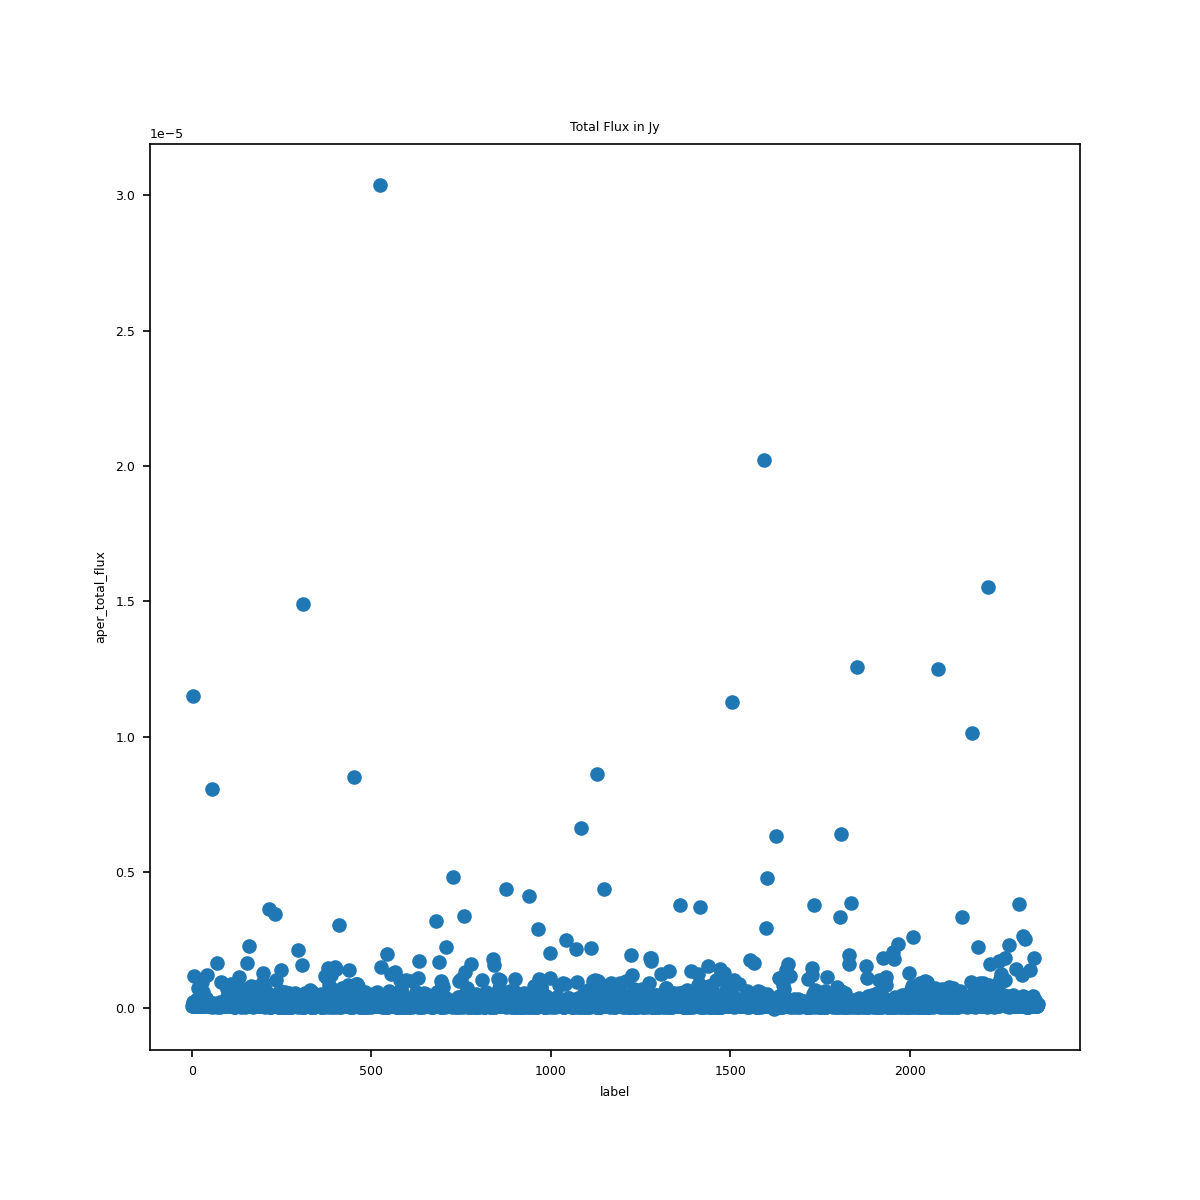

In [18]:
create_scatterplot(catalog['label'], catalog['aper_total_flux'],title='Total Flux in '+str(catalog['aper_total_flux'].unit))

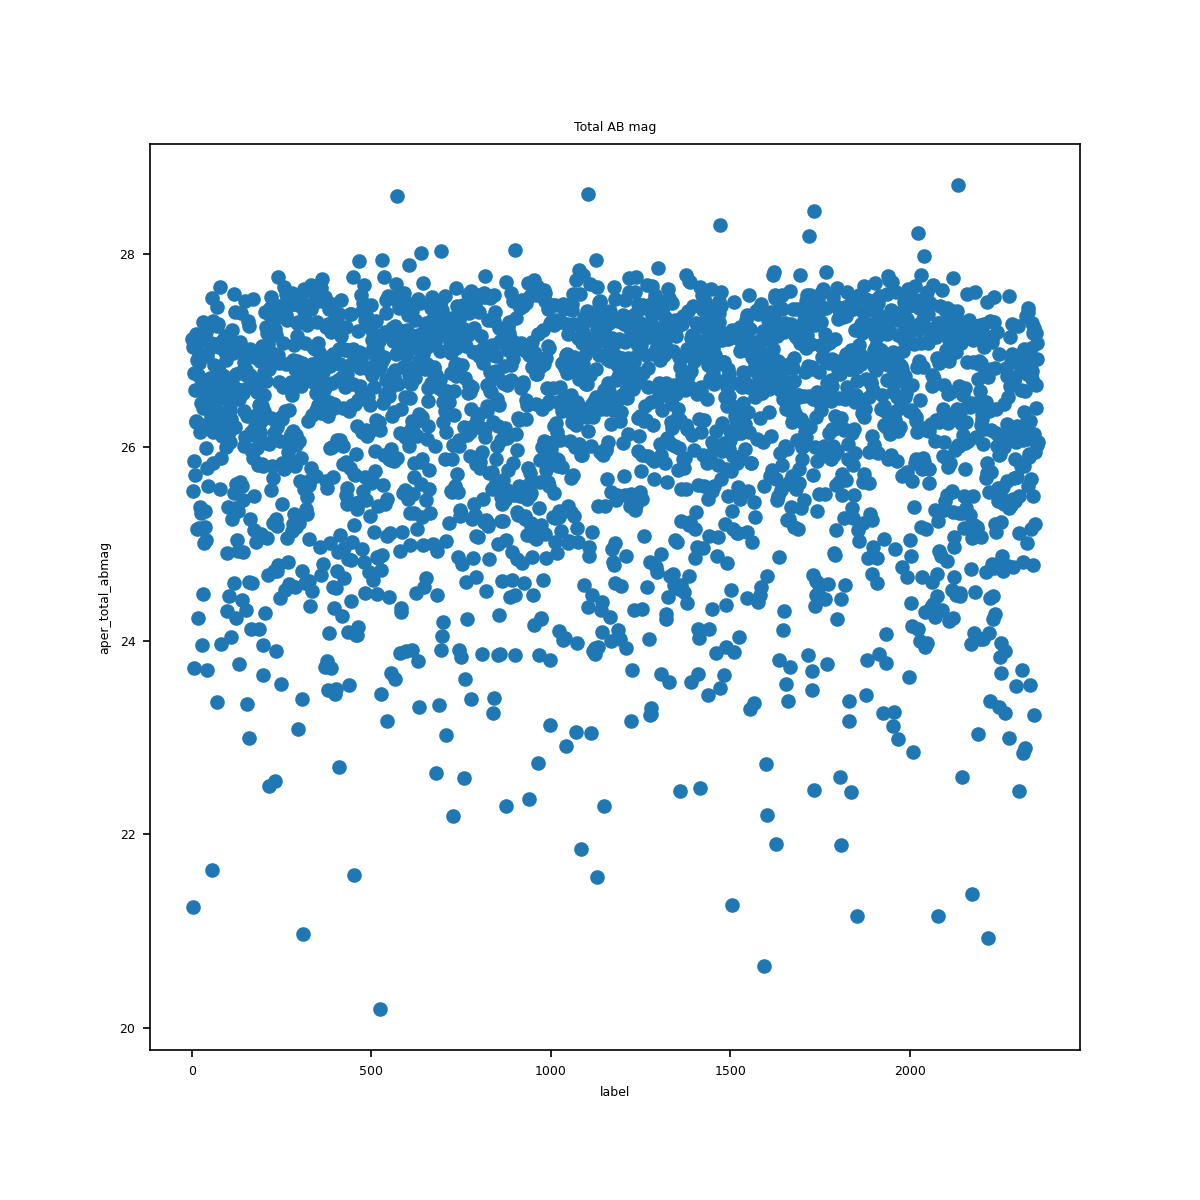

In [19]:
create_scatterplot(catalog['label'], catalog['aper_total_abmag'],title='Total AB mag')

[Top of Page](#title_ID)

<a id="manual"></a>
# Manually Find Matches 

Since this is a simulated data set, we can compare the output catalog information from the pipeline with the input catalog information used to create the simulation. Grab the input catalog RA, Dec values and the output catalog RA, Dec values.

In [20]:
test_outputs = get_input_table(file_names[4])
in_ra = test_outputs['In_RA'].data
in_dec = test_outputs['In_Dec'].data
out_ra = catalog['sky_centroid'].ra.deg
out_dec = catalog['sky_centroid'].dec.deg

Set the tolerance and initialize our counters. 

In [21]:
tol = 1.e-3
found_count=0
multiples_count=0
missed_count=0

Below we loop through the input RA, Dec values and compare them to the RA, Dec values in the output catalog. For cases where there are multiple matches for our tolerance level, count those cases. 

In [22]:
for ra,dec,idx in zip(in_ra, in_dec,range(len(test_outputs))):

    match = np.where((np.abs(ra-out_ra) < tol) & (np.abs(dec-out_dec) < tol))
    
    if np.size(match) == 1: 
        found_count +=1 
        test_outputs['Detected'][idx] = 'Y'
        test_outputs['Out_RA'][idx] = out_ra[match]
        test_outputs['Out_Dec'][idx] = out_dec[match]
        test_outputs['RA_Diff'][idx] = np.abs(ra-out_ra[match])
        test_outputs['Dec_Diff'][idx] = np.abs(dec-out_dec[match])  

    if np.size(match) > 1:  
        multiples_count +=1       
        
    if np.size(match) < 1:
        missed_count +=1

Let's see how it did. 

In [23]:
total_percent_found = (found_count/len(test_outputs))*100

print('\n')
print('SNR threshold used for pipeline: ',img3.source_catalog.snr_threshold)
print('Total found:',found_count)
print('Total missed:',missed_count)
print('Number of multiples: ',multiples_count)
print('Total number of input sources:',len(test_outputs))
print('Total number in output catalog:',len(catalog))
print('Total percent found:',total_percent_found)
print('\n')



SNR threshold used for pipeline:  5
Total found: 2108
Total missed: 1241
Number of multiples:  16146
Total number of input sources: 19495
Total number in output catalog: 2357
Total percent found: 10.813028981790202




### Use photutils to find catalog matches

Photutils includes a package to match sources between catalogs by providing a max separation value. Set that value and compare the two catalogs.

In [24]:
catalog_in = SkyCoord(ra=in_ra*u.degree, dec=in_dec*u.degree)
catalog_out = SkyCoord(ra=out_ra*u.degree, dec=out_dec*u.degree)

In [25]:
max_sep = 1.0 * u.arcsec

In [26]:
# idx, d2d, d3d = cat_in.match_to_catalog_3d(cat_out)
idx, d2d, d3d = catalog_in.match_to_catalog_sky(catalog_out)
sep_constraint = d2d < max_sep
catalog_in_matches = catalog_in[sep_constraint]
catalog_out_matches = catalog_out[idx[sep_constraint]]

Now, ```catalog_in_matches``` and ```catalog_out_matches``` are the matched sources in ```catalog_in``` and ```catalog_out```, respectively, which are separated less than our ```max_sep``` value.

In [27]:
print('Number of matched sources using max separation of '+str(max_sep)+': ',len(catalog_out_matches))

Number of matched sources using max separation of 1.0 arcsec:  7099


<a id="about_ID"></a>
## About this Notebook
**Author:** Alicia Canipe, Senior Staff Scientist, NIRCam
<br>**Updated On:** 05/26/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 